In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [2]:
class FashionMNISTManager:
    """
    A class to handle data preparation, loading, and EDA for Fashion-MNIST project (Phase 1).
    """
    def __init__(self, data_root="./data", batch_size=128, seed=42, val_ratio=0.1):
        self.data_root = data_root
        self.batch_size = batch_size
        self.seed = seed
        self.val_ratio = val_ratio

        self.class_names = [
            "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
        ]

        # Determine device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Placeholders
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

        # Initialize
        self._set_seed()
        self._prepare_transforms()

    def _set_seed(self):
        """Sets seed for reproducibility."""
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        print(f"[INFO] Seed set to {self.seed}")

    def _prepare_transforms(self):
        """Defines the preprocessing pipeline."""
        # Standard transform for VAE input (Normalized to [-1, 1])
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        # Raw transform for EDA (Just [0, 1])
        self.eda_transform = transforms.ToTensor()

    def prepare_data(self):
        """Downloads data, splits into train/val, and creates loaders."""
        print("[INFO] Loading and Splitting Data...")

        # Load Full Train Data
        full_train_dataset = datasets.FashionMNIST(
            root=self.data_root, train=True, download=True, transform=self.transform
        )

        # Load Test Data
        self.test_dataset = datasets.FashionMNIST(
            root=self.data_root, train=False, download=True, transform=self.transform
        )

        # Split Train/Val
        n_total = len(full_train_dataset)
        n_val = int(n_total * self.val_ratio)
        n_train = n_total - n_val

        self.train_dataset, self.val_dataset = random_split(
            full_train_dataset,
            [n_train, n_val],
            generator=torch.Generator().manual_seed(self.seed)
        )

        # Create DataLoaders
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

        self.report_data_stats()

    def report_data_stats(self):
        """
        Reports the number of samples in train/val/test sets and the shape of each sample.
        """
        if self.train_dataset is None:
            raise ValueError("Data not prepared. Call prepare_data() first.")

        # Get one sample from each dataset to inspect shape
        train_sample, _ = self.train_dataset[0]
        val_sample, _ = self.val_dataset[0]
        test_sample, _ = self.test_dataset[0]

        print("=" * 50)
        print("DATA STATISTICS REPORT")
        print("=" * 50)
        print(f"Train samples      : {len(self.train_dataset):,}")
        print(f"Validation samples : {len(self.val_dataset):,}")
        print(f"Test samples       : {len(self.test_dataset):,}")
        print("-" * 50)
        print("Shape of each sample:")
        print(f"  Train sample shape     : {train_sample.shape}")
        print(f"  Validation sample shape: {val_sample.shape}")
        print(f"  Test sample shape      : {test_sample.shape}")
        print("=" * 50)


    def get_loaders(self):
        """Returns the data loaders."""
        if self.train_loader is None:
            raise ValueError("Data not prepared. Call prepare_data() first.")
        return self.train_loader, self.val_loader, self.test_loader

    def sanity_check(self, n=25):
        """Visualizes a batch of images to check data integrity."""
        print("[INFO] Performing Sanity Check...")
        images, labels = next(iter(self.train_loader))

        images = images[:n]
        labels = labels[:n]

        # Denormalize: [-1, 1] -> [0, 1] for plotting
        images = images * 0.5 + 0.5

        plt.figure(figsize=(10, 10))
        for i in range(n):
            plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].squeeze(), cmap="gray")
            plt.title(self.class_names[labels[i]])
            plt.axis("off")
        plt.suptitle(f"Sanity Check: Batch of {n} Images", fontsize=16)
        plt.tight_layout()
        plt.show()

    def perform_eda(self):
        """Performs Exploratory Data Analysis."""
        print("[INFO] Starting EDA...")
        self._plot_class_distribution()
        self._plot_pixel_stats()

    def _plot_class_distribution(self):
        """Helper to plot class distribution."""
        subset_indices = self.train_dataset.indices
        original_dataset = self.train_dataset.dataset
        train_labels = [original_dataset.targets[i].item() for i in subset_indices]

        plt.figure(figsize=(10, 5))
        sns.countplot(x=train_labels)
        plt.xticks(ticks=range(10), labels=self.class_names, rotation=45)
        plt.title("Class Distribution in Training Set")
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.show()

    def _plot_pixel_stats(self):
        """
        Helper to plot pixel histograms using ALL data (No Sampling).
        Uses a separate raw loader to get [0,1] values.
        """
        # Load temporary raw dataset (No normalization)
        eda_dataset = datasets.FashionMNIST(
            root=self.data_root, train=True, download=True, transform=self.eda_transform
        )

        print(" -> Collecting ALL pixel statistics (this might take a few seconds)...")

        # Use a large batch size for faster iteration
        eda_loader = DataLoader(eda_dataset, batch_size=2048, num_workers=2, shuffle=False)

        all_means = []
        all_pixels = []

        for imgs, _ in eda_loader:
            # Flatten images in the batch -> [batch_size, 784]
            batch_flat = imgs.view(imgs.size(0), -1).numpy()

            # Mean per image
            all_means.extend(batch_flat.mean(axis=1))

            # Append ALL pixels to the list
            all_pixels.append(batch_flat.flatten())

        # Concatenate everything into one massive array
        # Total pixels approx: 60,000 * 784 = ~47 million floats
        all_pixels = np.concatenate(all_pixels)
        all_means = np.array(all_means)

        print(f" -> Analyzed {len(all_pixels):,} pixels across {len(all_means):,} images.")

        # Plot 1: Pixel Intensity Histogram (Full Data)
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.hist(all_pixels, bins=50, color='purple', alpha=0.7)
        plt.title("Pixel Intensity Histogram (All Data [0,1])")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

        # Plot 2: Mean Pixel Intensity per Image
        plt.subplot(1, 2, 2)
        plt.hist(all_means, bins=50, color='teal', alpha=0.7)
        plt.title("Mean Pixel Intensity per Image")
        plt.xlabel("Mean Intensity")
        plt.ylabel("Count")

        plt.tight_layout()
        plt.show()

In [3]:
# 1. Instantiation
data_manager = FashionMNISTManager(batch_size=128, seed=42)

[INFO] Seed set to 42


In [4]:
# 2. Preparation (Download, Split, Loaders)
data_manager.prepare_data()

[INFO] Loading and Splitting Data...
DATA STATISTICS REPORT
Train samples      : 54,000
Validation samples : 6,000
Test samples       : 10,000
--------------------------------------------------
Shape of each sample:
  Train sample shape     : torch.Size([1, 28, 28])
  Validation sample shape: torch.Size([1, 28, 28])
  Test sample shape      : torch.Size([1, 28, 28])


[INFO] Performing Sanity Check...


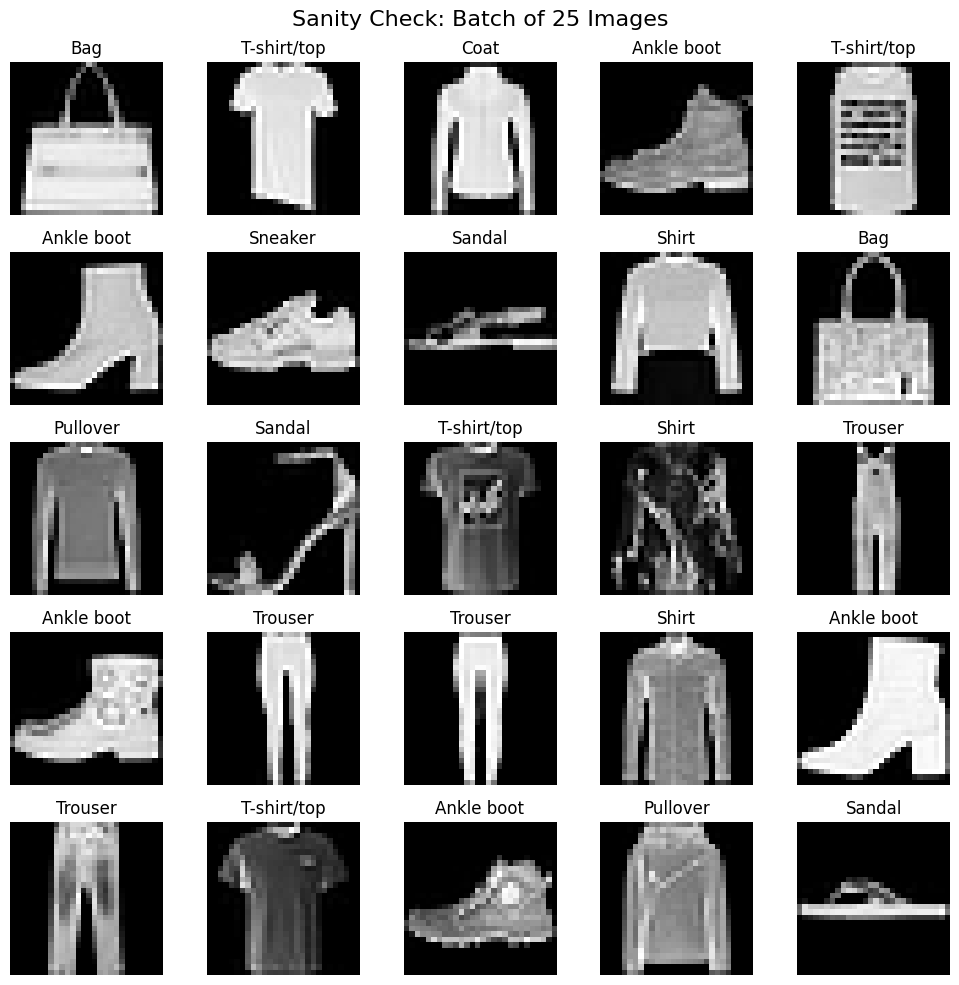

In [5]:
# 3. Sanity Check (Visualizing batch)
data_manager.sanity_check()

[INFO] Starting EDA...


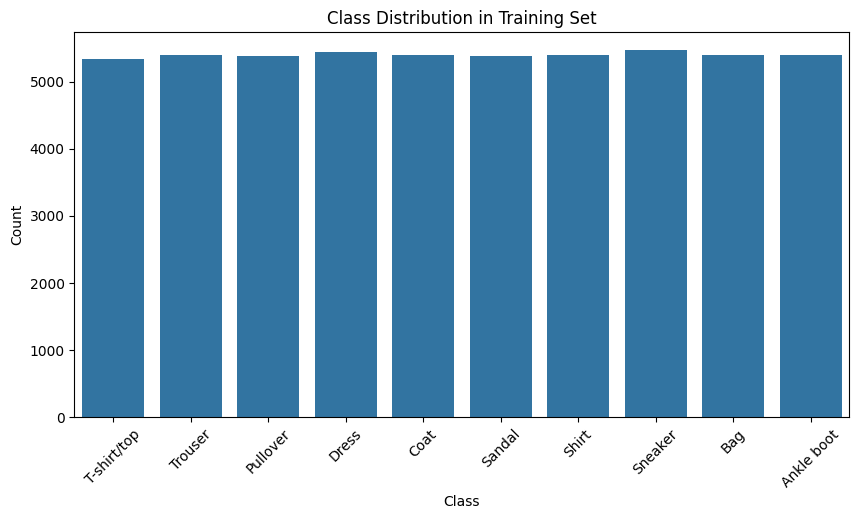

 -> Collecting ALL pixel statistics (this might take a few seconds)...
 -> Analyzed 47,040,000 pixels across 60,000 images.


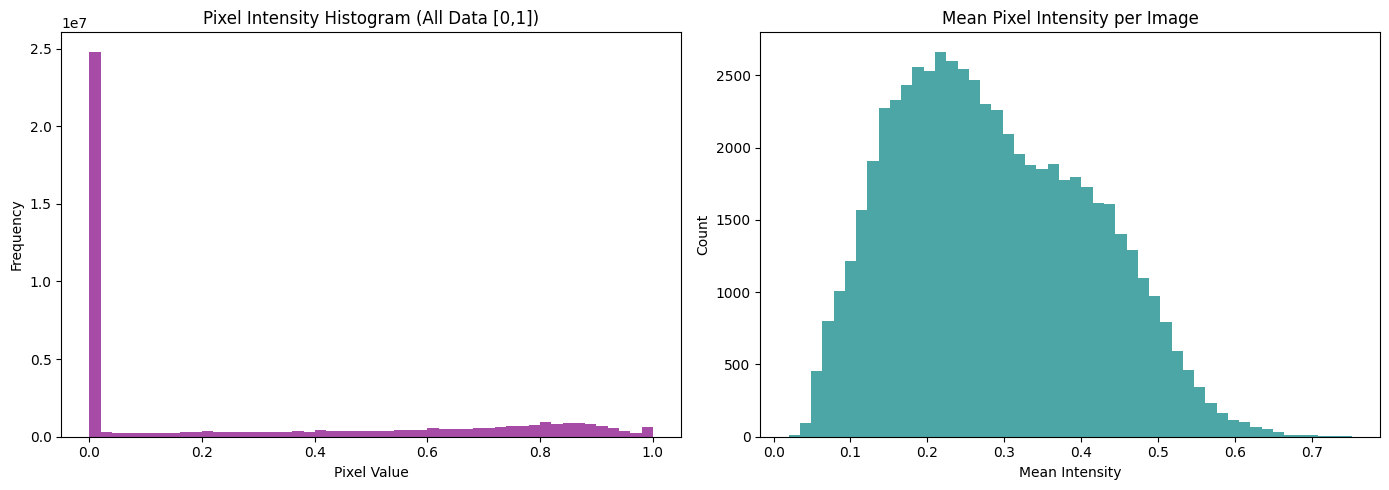

In [6]:
# 4. EDA (Class Dist, Pixel Histograms)
data_manager.perform_eda()

In [7]:
# 5. Access Loaders for Phase 2
train_loader, val_loader, test_loader = data_manager.get_loaders()
print("\n[INFO] Phase 1 Completed Successfully. Loaders are ready for Phase 2.")


[INFO] Phase 1 Completed Successfully. Loaders are ready for Phase 2.
